In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle
import joblib

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.lgb import fit_lgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base
from feature_engineering.fe_xgb import generate_features

MODEL_NAME = "lgb_model"
PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-31 00:18:30.916342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 00:18:31.394790: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-31 00:18:33.082335: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_110


In [2]:
# 特徴生成
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
train, features = generate_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [04:13<00:00,  1.09it/s]


,anglez,anglez_diff_abs,anglez_diff_abs_clip5,anglez_mean,enmo,enmo_diff_abs,enmo_mean,minutes,same_count,total_seconds,...,enmo_rolling_median_100_shift_1000,anglez_diff_abs_clip5_rolling_median_100_shift_1000,enmo_std_rolling_median_100_shift_1000,anglez_diff_abs_clip5_std_rolling_median_100_shift_1000,enmo_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_rolling_square_mean_100_shift_1000,enmo_std_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_std_rolling_square_mean_100_shift_1000,reduce_step,fold
27,-88.181526,0.078712,0.078712,-12.090329,0.029175,0.000292,0.030480,597.5,0.0,47397.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,659,3
28,-88.507393,0.106242,0.106242,-7.547437,0.029108,0.000433,0.051443,717.5,0.0,47517.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,683,3
29,-89.259064,0.057546,0.057546,-10.070161,0.029858,0.000262,0.104063,837.5,0.0,47637.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,707,3
30,-87.457848,0.147454,0.147454,-0.726222,0.029458,0.000533,0.095024,957.5,0.0,47757.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,731,3
31,-86.225922,0.169739,0.169739,-5.723403,0.030287,0.001758,0.092043,1077.5,0.0,47877.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,755,3


(515056, 1307)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_lgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG[MODEL_NAME]["lightgbm"], 
        es_rounds=100,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])

    # 保存
    for i, model in enumerate(models):
        joblib.dump(model, os.path.join(CFG["output_dir"], f'lgb_{event}_fold_{i}.pkl'))
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)

with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[100]	valid_0's rmse: 1.34647	valid_0's l2: 1.81299
[200]	valid_0's rmse: 1.15841	valid_0's l2: 1.34192
[300]	valid_0's rmse: 1.11962	valid_0's l2: 1.25354
[400]	valid_0's rmse: 1.11074	valid_0's l2: 1.23374
[500]	valid_0's rmse: 1.108	valid_0's l2: 1.22767
[600]	valid_0's rmse: 1.10693	valid_0's l2: 1.2253
[700]	valid_0's rmse: 1.1063	valid_0's l2: 1.22391
[800]	valid_0's rmse: 1.10588	valid_0's l2: 1.22297
[900]	valid_0's rmse: 1.10571	valid_0's l2: 1.22259
[1000]	valid_0's rmse: 1.10529	valid_0's l2: 1.22166
[1100]	valid_0's rmse: 1.10485	valid_0's l2: 1.22069
[1200]	valid_0's rmse: 1.10488	valid_0's l2: 1.22076


 20%|██        | 1/5 [02:33<10:15, 153.85s/it]

== fold 1 ==
[100]	valid_0's rmse: 1.38098	valid_0's l2: 1.90712
[200]	valid_0's rmse: 1.18295	valid_0's l2: 1.39938
[300]	valid_0's rmse: 1.13924	valid_0's l2: 1.29788
[400]	valid_0's rmse: 1.12836	valid_0's l2: 1.27319
[500]	valid_0's rmse: 1.12512	valid_0's l2: 1.2659
[600]	valid_0's rmse: 1.12344	valid_0's l2: 1.26211
[700]	valid_0's rmse: 1.12245	valid_0's l2: 1.2599
[800]	valid_0's rmse: 1.12163	valid_0's l2: 1.25806
[900]	valid_0's rmse: 1.12125	valid_0's l2: 1.2572
[1000]	valid_0's rmse: 1.1207	valid_0's l2: 1.25596
[1100]	valid_0's rmse: 1.1204	valid_0's l2: 1.25529
[1200]	valid_0's rmse: 1.12018	valid_0's l2: 1.2548
[1300]	valid_0's rmse: 1.12004	valid_0's l2: 1.25448
[1400]	valid_0's rmse: 1.11995	valid_0's l2: 1.25429
[1500]	valid_0's rmse: 1.11979	valid_0's l2: 1.25393
[1600]	valid_0's rmse: 1.11997	valid_0's l2: 1.25434


 40%|████      | 2/5 [05:44<08:46, 175.43s/it]

== fold 2 ==
[100]	valid_0's rmse: 1.38906	valid_0's l2: 1.92949
[200]	valid_0's rmse: 1.20659	valid_0's l2: 1.45586
[300]	valid_0's rmse: 1.16477	valid_0's l2: 1.3567
[400]	valid_0's rmse: 1.1548	valid_0's l2: 1.33357
[500]	valid_0's rmse: 1.15104	valid_0's l2: 1.32488
[600]	valid_0's rmse: 1.14963	valid_0's l2: 1.32166
[700]	valid_0's rmse: 1.14924	valid_0's l2: 1.32076
[800]	valid_0's rmse: 1.14925	valid_0's l2: 1.32077
[900]	valid_0's rmse: 1.1487	valid_0's l2: 1.31951
[1000]	valid_0's rmse: 1.14837	valid_0's l2: 1.31875
[1100]	valid_0's rmse: 1.14834	valid_0's l2: 1.31869
[1200]	valid_0's rmse: 1.14817	valid_0's l2: 1.31829
[1300]	valid_0's rmse: 1.14798	valid_0's l2: 1.31785
[1400]	valid_0's rmse: 1.14799	valid_0's l2: 1.31788
[1500]	valid_0's rmse: 1.1479	valid_0's l2: 1.31768
[1600]	valid_0's rmse: 1.14795	valid_0's l2: 1.3178


 60%|██████    | 3/5 [08:53<06:03, 181.87s/it]

== fold 3 ==
[100]	valid_0's rmse: 1.33347	valid_0's l2: 1.77815
[200]	valid_0's rmse: 1.13118	valid_0's l2: 1.27958
[300]	valid_0's rmse: 1.08642	valid_0's l2: 1.18031
[400]	valid_0's rmse: 1.07495	valid_0's l2: 1.15552
[500]	valid_0's rmse: 1.07169	valid_0's l2: 1.14852
[600]	valid_0's rmse: 1.0707	valid_0's l2: 1.14641
[700]	valid_0's rmse: 1.06999	valid_0's l2: 1.14489
[800]	valid_0's rmse: 1.07002	valid_0's l2: 1.14494


 80%|████████  | 4/5 [10:52<02:36, 156.74s/it]

== fold 4 ==
[100]	valid_0's rmse: 1.43367	valid_0's l2: 2.05542
[200]	valid_0's rmse: 1.23998	valid_0's l2: 1.53756
[300]	valid_0's rmse: 1.20035	valid_0's l2: 1.44083
[400]	valid_0's rmse: 1.19077	valid_0's l2: 1.41793
[500]	valid_0's rmse: 1.18745	valid_0's l2: 1.41003
[600]	valid_0's rmse: 1.18615	valid_0's l2: 1.40695
[700]	valid_0's rmse: 1.1855	valid_0's l2: 1.40541
[800]	valid_0's rmse: 1.18527	valid_0's l2: 1.40488
[900]	valid_0's rmse: 1.18505	valid_0's l2: 1.40434
[1000]	valid_0's rmse: 1.18483	valid_0's l2: 1.40382


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[100]	valid_0's rmse: 1.37446	valid_0's l2: 1.88915
[200]	valid_0's rmse: 1.18216	valid_0's l2: 1.39749
[300]	valid_0's rmse: 1.13643	valid_0's l2: 1.29148
[400]	valid_0's rmse: 1.12357	valid_0's l2: 1.26241
[500]	valid_0's rmse: 1.11993	valid_0's l2: 1.25423
[600]	valid_0's rmse: 1.11845	valid_0's l2: 1.25094
[700]	valid_0's rmse: 1.11782	valid_0's l2: 1.24953
[800]	valid_0's rmse: 1.11733	valid_0's l2: 1.24843


 20%|██        | 1/5 [01:58<07:55, 118.96s/it]

== fold 1 ==
[100]	valid_0's rmse: 1.39751	valid_0's l2: 1.95302
[200]	valid_0's rmse: 1.19244	valid_0's l2: 1.42192
[300]	valid_0's rmse: 1.14055	valid_0's l2: 1.30086
[400]	valid_0's rmse: 1.12423	valid_0's l2: 1.2639
[500]	valid_0's rmse: 1.11847	valid_0's l2: 1.25097
[600]	valid_0's rmse: 1.1165	valid_0's l2: 1.24657
[700]	valid_0's rmse: 1.1159	valid_0's l2: 1.24523
[800]	valid_0's rmse: 1.11568	valid_0's l2: 1.24474
[900]	valid_0's rmse: 1.11498	valid_0's l2: 1.24319
[1000]	valid_0's rmse: 1.11485	valid_0's l2: 1.2429


 40%|████      | 2/5 [04:17<06:30, 130.29s/it]

== fold 2 ==
[100]	valid_0's rmse: 1.38356	valid_0's l2: 1.91425
[200]	valid_0's rmse: 1.19166	valid_0's l2: 1.42006
[300]	valid_0's rmse: 1.14736	valid_0's l2: 1.31643
[400]	valid_0's rmse: 1.13496	valid_0's l2: 1.28813
[500]	valid_0's rmse: 1.13094	valid_0's l2: 1.27903
[600]	valid_0's rmse: 1.12954	valid_0's l2: 1.27585
[700]	valid_0's rmse: 1.12814	valid_0's l2: 1.2727
[800]	valid_0's rmse: 1.12687	valid_0's l2: 1.26984
[900]	valid_0's rmse: 1.12651	valid_0's l2: 1.26902
[1000]	valid_0's rmse: 1.12615	valid_0's l2: 1.26821
[1100]	valid_0's rmse: 1.126	valid_0's l2: 1.26788
[1200]	valid_0's rmse: 1.12576	valid_0's l2: 1.26734
[1300]	valid_0's rmse: 1.12562	valid_0's l2: 1.26702
[1400]	valid_0's rmse: 1.12526	valid_0's l2: 1.26621
[1500]	valid_0's rmse: 1.12523	valid_0's l2: 1.26614
[1600]	valid_0's rmse: 1.12507	valid_0's l2: 1.26578
[1700]	valid_0's rmse: 1.12455	valid_0's l2: 1.26462
[1800]	valid_0's rmse: 1.12429	valid_0's l2: 1.26403
[1900]	valid_0's rmse: 1.12397	valid_0's l2: 

 60%|██████    | 3/5 [07:49<05:35, 167.81s/it]

== fold 3 ==
[100]	valid_0's rmse: 1.412	valid_0's l2: 1.99374
[200]	valid_0's rmse: 1.24459	valid_0's l2: 1.54899
[300]	valid_0's rmse: 1.21232	valid_0's l2: 1.46972
[400]	valid_0's rmse: 1.20427	valid_0's l2: 1.45027
[500]	valid_0's rmse: 1.20132	valid_0's l2: 1.44317
[600]	valid_0's rmse: 1.20054	valid_0's l2: 1.4413
[700]	valid_0's rmse: 1.19993	valid_0's l2: 1.43984
[800]	valid_0's rmse: 1.19946	valid_0's l2: 1.4387
[900]	valid_0's rmse: 1.19925	valid_0's l2: 1.4382
[1000]	valid_0's rmse: 1.19893	valid_0's l2: 1.43744
[1100]	valid_0's rmse: 1.19898	valid_0's l2: 1.43756


 80%|████████  | 4/5 [10:03<02:34, 154.49s/it]

== fold 4 ==
[100]	valid_0's rmse: 1.49193	valid_0's l2: 2.22586
[200]	valid_0's rmse: 1.31875	valid_0's l2: 1.73909
[300]	valid_0's rmse: 1.27761	valid_0's l2: 1.6323
[400]	valid_0's rmse: 1.26404	valid_0's l2: 1.59779
[500]	valid_0's rmse: 1.25905	valid_0's l2: 1.58522
[600]	valid_0's rmse: 1.25749	valid_0's l2: 1.58127
[700]	valid_0's rmse: 1.25696	valid_0's l2: 1.57994
[800]	valid_0's rmse: 1.25638	valid_0's l2: 1.57848
[900]	valid_0's rmse: 1.2558	valid_0's l2: 1.57703
[1000]	valid_0's rmse: 1.25517	valid_0's l2: 1.57544
[1100]	valid_0's rmse: 1.25476	valid_0's l2: 1.57442
[1200]	valid_0's rmse: 1.25433	valid_0's l2: 1.57335
[1300]	valid_0's rmse: 1.25383	valid_0's l2: 1.57208
[1400]	valid_0's rmse: 1.25338	valid_0's l2: 1.57097
[1500]	valid_0's rmse: 1.2533	valid_0's l2: 1.57077
[1600]	valid_0's rmse: 1.253	valid_0's l2: 1.57002
[1700]	valid_0's rmse: 1.25294	valid_0's l2: 1.56985


100%|██████████| 5/5 [12:59<00:00, 155.97s/it]


## Dynamic-Range NMS

<AxesSubplot: >

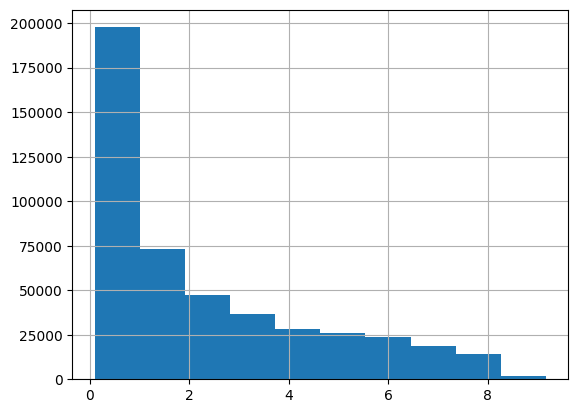

In [4]:
train = train[train["score"] > 0.1]
train["score"].hist()

In [5]:
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from tqdm import tqdm

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:10<00:00, 26.80it/s]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7655


event   tolerance
onset   12           0.178401
        36           0.595004
        60           0.749942
        90           0.817291
        120          0.845138
        150          0.866046
        180          0.877200
        240          0.895186
        300          0.902194
        360          0.909206
wakeup  12           0.172684
        36           0.619187
        60           0.746441
        90           0.811219
        120          0.843908
        150          0.867002
        180          0.881572
        240          0.900625
        300          0.911554
        360          0.920557
dtype: float64